In [ ]:
#@title
pip install kaggle

In [24]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ahmedali2019","key":"f87c00b4560debffb065fc3c68ec5118"}'}

In [25]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [26]:
!kaggle datasets download -d deadskull7/fer2013


fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [27]:
import zipfile
from tqdm import tqdm

In [28]:
zf = zipfile.ZipFile('fer2013.zip')
uncompress_size = sum((file.file_size for file in zf.infolist()))
extracted_size = 0
for file in tqdm(zf.infolist()):
    extracted_size += file.file_size
    zf.extract(file)

100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


In [ ]:
ls

In [29]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np

In [30]:
dataset_path = '/content/fer2013.csv'
image_size=(48,48)
# parameters
batch_size = 32
num_epochs = 200
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = 'models/'
l2_regularization=0.01


In [31]:

def load_fer2013():
	data = pd.read_csv(dataset_path)
	pixels = data['pixels'].tolist()
	width, height = 48, 48
	faces = []
	for pixel_sequence in tqdm(pixels):
		face = [int(pixel) for pixel in pixel_sequence.split(' ')]
		face = np.asarray(face).reshape(width, height)
		face = cv2.resize(face.astype('uint8'),image_size)
		faces.append(face.astype('float32'))
	faces = np.asarray(faces)
	faces = np.expand_dims(faces, -1)
	emotions = pd.get_dummies(data['emotion']).to_numpy()
 #.as_matrix()
	return faces, emotions

#df['Price']




In [32]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [33]:

# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


In [34]:
regularization = l2(l2_regularization)

# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)

model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 46, 46, 8)    72          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 46, 46, 8)    32          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 46, 46, 8)    0           batch_normalization_15[0][0]     
____________________________________________________________________________________________

In [35]:

# loading dataset
faces, emotions = load_fer2013()



100%|██████████| 35887/35887 [00:21<00:00, 1664.64it/s]


In [36]:
faces = preprocess_input(faces)

In [37]:
num_samples, num_classes = emotions.shape

In [38]:
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [39]:
history =model.fit_generator(data_generator.flow(xtrain, ytrain,
                                            batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1,
                        validation_data=(xtest,ytest))
model.save("my_Model.h5")
model.save("my_Model.hdf5")


Epoch 1/200
898/897 [==============================] - 44s 49ms/step - loss: 1.7589 - accuracy: 0.3346 - val_loss: 1.7295 - val_accuracy: 0.3863
Epoch 2/200
898/897 [==============================] - 35s 38ms/step - loss: 1.5070 - accuracy: 0.4327 - val_loss: 1.6036 - val_accuracy: 0.4138
Epoch 3/200
898/897 [==============================] - 35s 39ms/step - loss: 1.3829 - accuracy: 0.4813 - val_loss: 1.4381 - val_accuracy: 0.4645
Epoch 4/200
898/897 [==============================] - 35s 39ms/step - loss: 1.3181 - accuracy: 0.5025 - val_loss: 1.3210 - val_accuracy: 0.4950
Epoch 5/200
898/897 [==============================] - 35s 39ms/step - loss: 1.2776 - accuracy: 0.5206 - val_loss: 1.2240 - val_accuracy: 0.5476
Epoch 6/200
898/897 [==============================] - 35s 39ms/step - loss: 1.2413 - accuracy: 0.5349 - val_loss: 1.2631 - val_accuracy: 0.5371
Epoch 7/200
898/897 [==============================] - 35s 39ms/step - loss: 1.2126 - accuracy: 0.5465 - val_loss: 1.2311 - val_ac

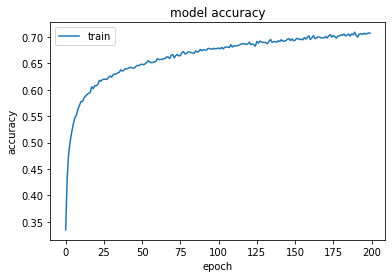

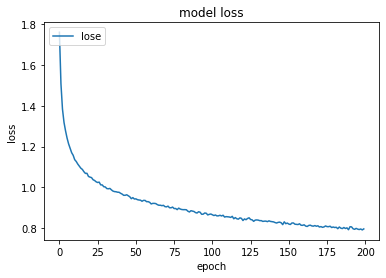

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['lose'], loc='upper left')
plt.show()

In [ ]:
print("ahemd_ali")

ahemd_ali


In [ ]:
print("youssef")

youssef


In [ ]:
print("ahmed_ali")

ahmed_ali


In [ ]:
print("ahmed_ali_ahmed")

ahmed_ali_ahmed
